In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
from glob import glob
from os.path import join
from marbleri.models import ResNet, StandardConvNet
from marbleri.nwp import HWRFSequence, BestTrackNetCDF, HWRFStep
from scipy.ndimage import gaussian_filter
import keras.backend as K

Using TensorFlow backend.


In [2]:
config = K.tf.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth = True
sess = K.tf.Session(config=config)
K.set_session(sess)

In [3]:
hwrf_path = "/glade/p/ral/nsap/rozoff/hfip/reforecast/"
hwrf_files = np.array(sorted(glob(hwrf_path + "*.nc")))
hwrf_fh = pd.Series(hwrf_files).str.split(".").str[-2].str[1:].astype(int)
hwrf_files_sub = hwrf_files[(hwrf_fh % 3 == 0) & (hwrf_fh < 75)]
print(hwrf_fh[:10])
print(hwrf_files[:10])
hs = HWRFStep(join(hwrf_path, "maria15l.2017092000.f024.nc"))
bt = BestTrackNetCDF()

0     0
1     3
2     6
3     9
4    12
5    15
6    18
7    21
8    24
9    27
dtype: int64
['/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f000.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f003.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f006.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f009.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f012.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f015.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f018.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f021.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f024.nc'
 '/glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f027.nc']


In [10]:
bt.get_storm_variables(["vmax_bt_new", "vmax_tcvitals", "mslp_bt", "vmax_nhc", "LAND", "vmax_bt", "LAT", "LAT_smooth", "LON", "LON_smooth"], 
                       hs.run_date, hs.storm_name, hs.storm_number[:-1], hs.basin, int(hs.forecast_hour))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [11]:
np.where(bt.bt_runs["l"]["STNUM"] == hs.storm_number[:-1])

(array([], dtype=int64),)

In [5]:
for col in bt.bt_runs["l"]:
    bt.bt_runs['l'][col] = bt.bt_runs["l"][col].str.strip().str.decode("utf-8")

In [74]:
hs.forecast_hour

'024'

In [13]:
list(hs.ds.variables.keys())

['TMP_P0_L100_GLL0',
 'TMP_P0_L103_GLL0',
 'RH_P0_L100_GLL0',
 'RH_P0_L103_GLL0',
 'PWAT_P0_L200_GLL0',
 'UGRD_P0_L100_GLL0',
 'UGRD_P0_L103_GLL0',
 'VGRD_P0_L100_GLL0',
 'VGRD_P0_L103_GLL0',
 'VVEL_P0_L100_GLL0',
 'HGT_P0_L100_GLL0',
 'HPBL_P0_L1_GLL0',
 'TCOND_P0_L100_GLL0',
 'TCOLC_P0_L200_GLL0',
 'CAPE_P0_L1_GLL0',
 'CIN_P0_L1_GLL0',
 'LAND_P0_L1_GLL0',
 'lat_0',
 'lon_0',
 'lv_ISBL0']

In [13]:
hs.get_variable('PWAT_P0_L200_GLL0')

<xarray.DataArray 'PWAT_P0_L200_GLL0' (lat_0: 601, lon_0: 601)>
[361201 values with dtype=float32]
Coordinates:
  * lat_0    (lat_0) float32 23.616 23.601 23.586 23.571 23.556 23.541 ...
  * lon_0    (lon_0) float32 288.5 288.515 288.53 288.545 288.56 288.575 ...
Attributes:
    initial_time:                                   09/20/2017 (00:00)
    forecast_time_units:                            hours
    forecast_time:                                  24
    level:                                          0.0
    level_type:                                     Entire atmosphere (consid...
    parameter_template_discipline_category_number:  [0 0 1 3]
    parameter_discipline_and_category:              Meteorological products, ...
    grid_type:                                      Latitude/longitude
    _FillValue:                                     1e+20
    units:                                          kg m-2
    long_name:                                      Precipitable water
 

In [7]:
hs.get_variable('UGRD_P0_L103_GLL0')[stride::stride, stride::stride].shape
print(np.arange(601)[stride:stride]

(30, 30)

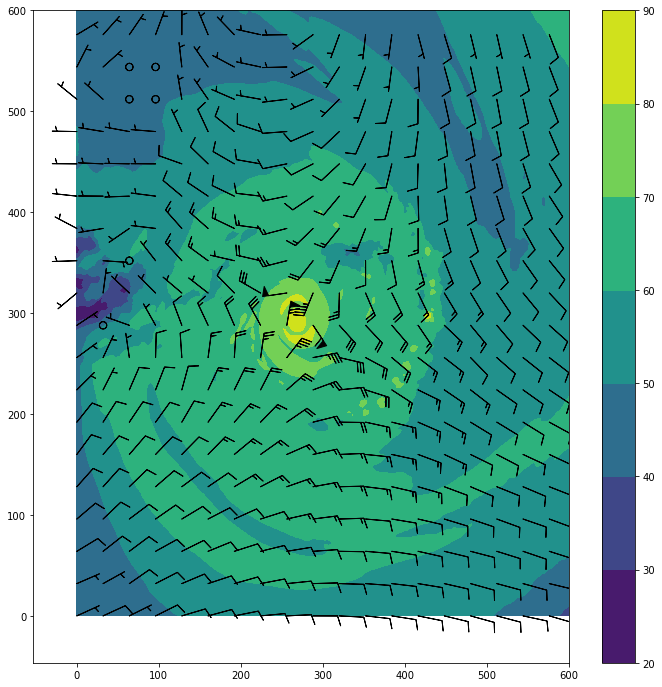

In [17]:
plt.figure(figsize=(12, 12))
plt.contourf(np.arange(601), np.arange(601), hs.get_variable('PWAT_P0_L200_GLL0'))
stride = 32
plt.barbs(np.arange(601)[::stride], np.arange(601)[::stride], 
          hs.get_variable('UGRD_P0_L103_GLL0').values[::stride, ::stride], 
          hs.get_variable('VGRD_P0_L103_GLL0').values[::stride, ::stride])
plt.colorbar()

In [47]:
hwrf_vars = ['UGRD_P0_L103_GLL0', 'VGRD_P0_L103_GLL0']
hwrf_levels = [None, None, None]
bt_inputs = ["LAT_smooth", "LON_smooth", "MIN_SLP_smooth"]
bt_labels = ["vmax_bt"]
batch_size = 32
x_start = 300 - 32
x_end = 300 + 32
hw_seq = HWRFSequence(hwrf_files_sub, bt, hwrf_vars, hwrf_levels, bt_inputs, bt_labels, batch_size, x_start=x_start, x_end=x_end)

In [6]:
%timeit output = hw_seq[1]

6.54 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
hwrf_files_fh = hwrf_files = sorted(glob(hwrf_path + "*f003.nc"))

var_counts = np.zeros(len(hwrf_files_fh), dtype=int)

for h, hwrf_file in enumerate(hwrf_files_fh):
    ds = Dataset(hwrf_file)
    var_counts[h] = len(list(ds.variables.keys()))
    ds.close()
    if h % 500 == 0:
        print(h, hwrf_file, var_counts[h])
    if var_counts[h] != 20:
        print(h, hwrf_file, var_counts[h])

0 /glade/p/ral/nsap/rozoff/hfip/reforecast/agatha02e.2016070218.f003.nc 20
500 /glade/p/ral/nsap/rozoff/hfip/reforecast/fifteen15e.2017091118.f003.nc 20


KeyboardInterrupt: 

In [56]:
ds = xr.open_dataset("/glade/p/ral/nsap/rozoff/hfip/reforecast/thirteen13l.2017090600.f002.nc")
print(list(ds.variables.keys()))
print(len(list(ds.variables.keys())))

['TMP_P0_L100_GLL0', 'UGRD_P0_L100_GLL0', 'UGRD_P0_L103_GLL0', 'VGRD_P0_L100_GLL0', 'VGRD_P0_L103_GLL0', 'HGT_P0_L100_GLL0', 'lat_0', 'lon_0', 'lv_ISBL0']
9


In [14]:
109624 / 64

1712.875

In [8]:
scn = StandardConvNet(output_activation="linear", use_dropout=True, dropout_alpha=0.2)
scn.build_network((64, 64, 2), (len(bt_inputs),), 1)
scn.compile_model()
scn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          (None, 64, 64, 2)    0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 2)    8           scn_input[0][0]                  
__________________________________________________________________________________________________
conv_00 (Conv2D)                (None, 64, 64, 16)   816         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
hidden_activation_00 (Activatio (None, 64, 64, 16)   0           conv_00[0][0]                    
__________________________________________________________________________________________________
pooling_00

In [9]:
out_history = scn.model.fit_generator(hw_seq, epochs=5, verbose=1, workers=16, 
                                      use_multiprocessing=True, shuffle=True)

Epoch 1/5
1981/1981 [==============================] - 1135s 573ms/step - loss: 806.5114
Epoch 2/5
1981/1981 [==============================] - 1085s 547ms/step - loss: 520.1348
Epoch 3/5
1981/1981 [==============================] - 1060s 535ms/step - loss: 499.1863
Epoch 4/5
1981/1981 [==============================] - 1083s 547ms/step - loss: 483.7775
Epoch 5/5
1981/1981 [==============================] - 1082s 546ms/step - loss: 475.6123


In [43]:
loss = (scn.model.output - 120) ** 2
grad_fields = K.gradients(loss, scn.model.input)
print(grad_fields)
#grad /= K.maximum(K.std(grad), K.epsilon())
grad_func = K.function(scn.model.input + [K.learning_phase()], grad_fields + [loss])

[<tf.Tensor 'gradients_8/AddN_3:0' shape=(?, 64, 64, 2) dtype=float32>, <tf.Tensor 'gradients_8/AddN_2:0' shape=(?, 3) dtype=float32>]


In [45]:
input_field = np.zeros((1, 64, 64, 2), dtype=np.float32)
input_scalar = np.zeros((1, 3), dtype=np.float32)
for i in range(1000):
    grad = grad_func([input_field, input_scalar, 0])
    input_field -= 0.1 * grad[0]
    input_scalar -= 0.1 * grad[1]


In [84]:
input_field.max()

43.79886

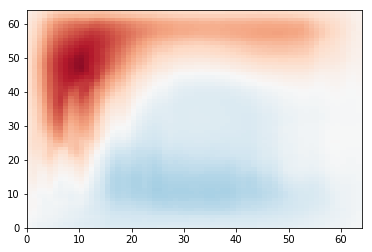

In [86]:
plt.pcolormesh(gaussian_filter(input_field[0, :, :, 0], 1), cmap="RdBu_r", vmin=-40, vmax=40)

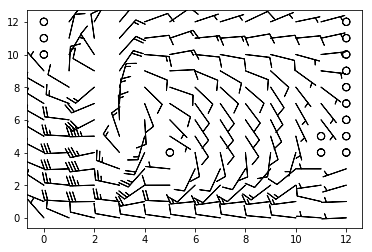

In [75]:
plt.barbs(gaussian_filter(input_field[0, ::-5, ::5, 0], input_field[0, ::-5, ::5, 1])

In [65]:
out = hw_seq[25]

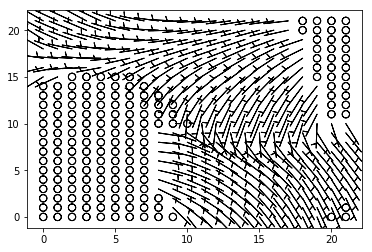

In [66]:
plt.barbs(out[0][0][0, ::3, ::3, 0], out[0][0][0, ::3, ::3, 1])

In [64]:
len(out[0])

2